# Google Colaboratory

https://colab.research.google.com/drive/1u5roadx9O6ELuX_9_v2Qwv4GuCYuaOM0?usp=sharing

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
from sklearn import preprocessing
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import duckdb

In [105]:
interactions_df = pd.read_csv('../data/cleaned_online_retail.csv')

In [106]:
interactions_df['invoicedate'] = pd.to_datetime(interactions_df['invoicedate'])
#Dropping unnecessary columns
if 'Unnamed: 0' in list(interactions_df.columns):
    interactions_df.drop(['Unnamed: 0'], axis=1, inplace=True)

interactions_df.dtypes

invoiceno               int64
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid              int64
country                object
amount                float64
dtype: object

In [107]:
le_product = preprocessing.LabelEncoder()
# cs_df["description_enc"] = cs_df["description"].astype('category').cat.codes

le_product.fit(list(interactions_df["description"]))
interactions_df["productid"] = le_product.transform(list(interactions_df["description"]))
interactions_df["productid"] = interactions_df["productid"].astype('category')

#  as all customers bought all products, we delete some random rows
# remove_n = 50000
# print(len(interactions_df))
# drop_indices = np.random.choice(interactions_df.index, remove_n, replace=False)
# interactions_df.drop(drop_indices, inplace=True)
# print(len(interactions_df))
                                       
interactions_df.head(10)

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,amount,productid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,3480
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,3488
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,816
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1686
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2601
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2790
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,1342
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,1454
8,536366,22632,HAND WARMER RED RETROSPOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,1452
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,204


In [108]:
print('Total products:', len(le_product.classes_))
print(le_product.classes_) # get the class names of product


product_classes = le_product.classes_
product_classes = {i: product_classes[i] for i in range(len(le_product.classes_))}

Total products: 3647
[' 4 PURPLE FLOCK DINNER CANDLES' " 50'S CHRISTMAS GIFT BAG LARGE"
 ' DOLLY GIRL BEAKER' ... 'ZINC WILLIE WINKIE  CANDLE STICK'
 'ZINC WIRE KITCHEN ORGANISER' 'ZINC WIRE SWEETHEART LETTER TRAY']


In [109]:
products_df = interactions_df.drop_duplicates(subset = ["productid", "description"])
products_df = products_df[["productid", "description"]]
products_df.head(10)

,productid,description
0,3480,WHITE HANGING HEART T-LIGHT HOLDER
1,3488,WHITE METAL LANTERN
2,816,CREAM CUPID HEARTS COAT HANGER
3,1686,KNITTED UNION FLAG HOT WATER BOTTLE
4,2601,RED WOOLLY HOTTIE WHITE HEART.
5,2790,SET 7 BABUSHKA NESTING BOXES
6,1342,GLASS STAR FROSTED T-LIGHT HOLDER
7,1454,HAND WARMER UNION JACK
8,1452,HAND WARMER RED RETROSPOT
9,204,ASSORTED COLOUR BIRD ORNAMENT


In [110]:
print('Total customers:', len(interactions_df['customerid'].unique()))
print('Total products:', len(le_product.classes_))

Total customers: 4338
Total products: 3647


In [111]:
product_quantity = duckdb.query("""
select customerid, COUNT(DISTINCT productid) AS total_unique_products 
from interactions_df group by customerid order by total_unique_products DESC
""").df()
product_quantity

,customerid,total_unique_products
0,14911,1786
1,12748,1765
2,17841,1320
3,14096,1119
4,14298,883
...,...,...
4333,13099,1
4334,17347,1
4335,17846,1
4336,15524,1


So, we want to suggest rest of the (3647-1786) = 1861 non-buiying products for customerid 14911.

In [112]:
users_interactions_count_df = interactions_df.groupby(['customerid', 'productid']).size().groupby('customerid').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['customerid']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 4338
# users with at least 5 interactions: 4338


In [113]:
users_with_enough_interactions_df.head(10)

,customerid
0,12346
1,12347
2,12348
3,12349
4,12350
5,12352
6,12353
7,12354
8,12355
9,12356


In [114]:
# users_interactions_count_df = users_interactions_count_df.to_frame()
# users_interactions_count_df = users_interactions_count_df.rename(columns = {0:'count'})
# users_interactions_count_df[users_interactions_count_df['count']<3647]

In [115]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'customerid',
               right_on = 'customerid')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 397884
# of interactions from users with at least 5 interactions: 397884


In [116]:
interactions_from_selected_users_df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,amount,productid
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,1861
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347,Iceland,25.2,322
2,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland,17.0,128
3,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland,39.0,783
4,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347,Iceland,23.4,1914


In [142]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['customerid', 'productid'])['quantity'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df = interactions_full_df[interactions_full_df['quantity']>0]
interactions_full_df

# of unique user/item interactions: 15820686


,customerid,productid,quantity
1861,12346,1861,16.179443
3712,12347,65,6.988685
3714,12347,67,3.700440
3715,12347,68,3.700440
3751,12347,104,6.189825
...,...,...,...
15820182,18287,3143,3.700440
15820194,18287,3155,4.954196
15820195,18287,3156,3.700440
15820233,18287,3194,5.614710


In [143]:
is_multi = interactions_full_df["customerid"].value_counts() > 4
interactions_full_df = interactions_full_df[interactions_full_df["customerid"].isin(is_multi[is_multi].index)]
interactions_full_df

,customerid,productid,quantity
3712,12347,65,6.988685
3714,12347,67,3.700440
3715,12347,68,3.700440
3751,12347,104,6.189825
3753,12347,106,6.189825
...,...,...,...
15820182,18287,3143,3.700440
15820194,18287,3155,4.954196
15820195,18287,3156,3.700440
15820233,18287,3194,5.614710


In [144]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['customerid'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 212876
# interactions on Test set: 53219


In [145]:
#Indexing by customerid to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('customerid')
interactions_train_indexed_df = interactions_train_df.set_index('customerid')
interactions_test_indexed_df = interactions_test_df.set_index('customerid')

In [146]:
interactions_train_indexed_df

,productid,quantity
customerid,,
14631,1136,3.700440
14390,1402,2.807355
13139,1818,3.459432
18122,538,1.000000
14261,1697,2.000000
...,...,...
15004,1524,1.000000
15104,1576,4.643856
13623,3079,1.000000


In [156]:
def get_items_interacted(person_id, _df):
    # Get the user's data and merge in the product information.
    interacted_items = _df.loc[person_id]['productid']
#     print(person_id,len(interacted_items))
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [165]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(products_df['productid'])
        non_interacted_items = all_items - interacted_items
        random.seed(seed)
#         print(len(non_interacted_items))
        non_interacted_items_sample = random.sample([*non_interacted_items], sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['productid']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['productid'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['productid'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 
#         print(interacted_items_count_testset)

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                   items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), 
                                   topn=100)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                  sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                  seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a 
            #random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['productid'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['productid'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
#             print(idx, person_id)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

## Popularity model

In [166]:
#Computes the most popular products
item_popularity_df = interactions_full_df.groupby('productid')['quantity'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,productid,quantity
0,3480,3231.753843
1,204,2991.770159
2,2125,2760.292502
3,1652,2622.457686
4,2194,2252.501581
5,2605,2102.522719
6,1816,2095.842110
7,1509,2045.057505
8,2167,2042.824386
9,1620,2039.757957


In [167]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['productid'].isin(items_to_ignore)] \
                               .sort_values('quantity', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'productid', 
                                                          right_on = 'productid')[['quantity', 'productid', 'description']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, products_df)

In [168]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
4079 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.17454292639846672, 'recall@10': 0.17890227174505346}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
148,71,71,357,0.198880,0.198880,14911
274,72,72,353,0.203966,0.203966,12748
190,35,35,264,0.132576,0.132576,17841
347,39,40,224,0.174107,0.178571,14096
15,14,15,177,0.079096,0.084746,14298
67,14,14,164,0.085366,0.085366,14606
8,16,18,144,0.111111,0.125000,14769
348,26,27,143,0.181818,0.188811,14156
130,29,29,140,0.207143,0.207143,14646
11,30,32,127,0.236220,0.251969,13089


## Collaborative Filtering

In [170]:
users_items_pivot_matrix_df = interactions_train_df.pivot(index='customerid', 
                                                          columns='productid', 
                                                          values='quantity').fillna(0)

users_items_pivot_matrix_df.head(10)

productid,1136,1402,1818,538,1697,1345,2367,3403,2874,260,...,908,2054,2458,903,652,970,2802,3136,1321,3473
customerid,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12354,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12355,0.0,0.0,0.0,0.0,0.0,0.0,2.807355,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,0.0,0.0,0.0,0.0,0.0,2.321928,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12357,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [172]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[12347, 12348, 12349, 12350, 12352, 12354, 12355, 12356, 12357, 12358]

In [173]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<4080x3596 sparse matrix of type '<class 'numpy.float64'>'
	with 212876 stored elements in Compressed Sparse Row format>

In [174]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [175]:
U.shape

(4080, 15)

In [176]:
Vt.shape

(15, 3596)

In [177]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [178]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 4.12077800e-02,  1.09289711e-01,  2.01763922e-01, ...,
        -5.38946146e-05,  2.68066174e-05, -1.04697800e-03],
       [-6.13504730e-03, -4.61581681e-02,  9.62149274e-02, ...,
        -6.84873472e-05,  1.46785053e-04,  3.24098529e-03],
       [ 2.30008340e-01,  7.48685096e-02,  1.21776690e-01, ...,
         2.83329804e-05, -6.90330702e-05, -1.12942731e-04],
       ...,
       [ 6.35447887e-03, -2.69692910e-03, -4.63091597e-02, ...,
        -8.69824039e-06,  3.76204923e-05, -5.39063654e-05],
       [ 2.71511871e-01, -4.33689173e-02,  3.14889558e+00, ...,
        -7.06287483e-05, -1.58491084e-04,  5.34096563e-03],
       [ 2.66857035e-02,  6.99998870e-02,  8.34038673e-02, ...,
         6.62093262e-05,  5.92702197e-05,  2.68193494e-03]])

In [179]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [180]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,12347,12348,12349,12350,12352,12354,12355,12356,12357,12358,...,18272,18274,18276,18277,18278,18280,18281,18282,18283,18287
productid,,,,,,,,,,,,,,,,,,,,,
1136,0.275623,0.273745,0.283109,0.275933,0.279357,0.280860,0.275478,0.276457,0.279538,0.274517,...,0.290038,0.275205,0.275593,0.274169,0.274154,0.273457,0.275146,0.274241,0.284755,0.275047
1402,0.278322,0.272158,0.276957,0.273577,0.275952,0.277921,0.274984,0.274891,0.278804,0.274402,...,0.280881,0.274343,0.274644,0.274127,0.273668,0.273861,0.274125,0.273882,0.272269,0.276764
1818,0.281989,0.277804,0.278817,0.281180,0.277226,0.292470,0.271685,0.280716,0.274102,0.275989,...,0.253585,0.271869,0.275231,0.279949,0.274707,0.272997,0.281330,0.272152,0.398850,0.277296
538,0.277930,0.276106,0.277178,0.275033,0.276565,0.273635,0.273859,0.276706,0.275315,0.274102,...,0.280810,0.274291,0.275075,0.275144,0.274469,0.274087,0.274293,0.273888,0.283293,0.275558
1697,0.275174,0.274110,0.274080,0.273898,0.274361,0.273778,0.274431,0.273875,0.276240,0.274110,...,0.272792,0.273958,0.274398,0.274285,0.274391,0.274256,0.274066,0.274134,0.274771,0.275335
1345,0.275480,0.275307,0.275680,0.273336,0.274218,0.277576,0.274451,0.282440,0.285318,0.275672,...,0.270439,0.274774,0.274719,0.275814,0.276300,0.274401,0.272509,0.274960,0.278455,0.285954
2367,0.340845,0.270916,0.282076,0.271529,0.288719,0.278801,0.293363,0.300787,0.291640,0.276855,...,0.278708,0.281232,0.279541,0.270958,0.273300,0.276044,0.272755,0.289336,0.248848,0.276182
3403,0.264755,0.278360,0.278501,0.273194,0.277870,0.277019,0.274174,0.279319,0.288607,0.274515,...,0.280762,0.275628,0.274437,0.274778,0.276675,0.275025,0.274539,0.274373,0.285304,0.274937
2874,0.295817,0.282260,0.285088,0.277040,0.279814,0.282543,0.277593,0.281035,0.290567,0.275611,...,0.294523,0.275334,0.274962,0.273062,0.274051,0.274861,0.274796,0.275523,0.280499,0.281382


In [181]:
len(cf_preds_df.columns)

4080

In [189]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['productid'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'productid', 
                                                          right_on = 'productid')[['productid', 'description']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, products_df)

In [190]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
4079 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.2932223454029576, 'recall@10': 0.2978259644112065}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
148,58,58,357,0.162465,0.162465,14911
274,61,62,353,0.172805,0.175637,12748
190,55,55,264,0.208333,0.208333,17841
347,44,44,224,0.196429,0.196429,14096
15,37,38,177,0.209040,0.214689,14298
67,26,26,164,0.158537,0.158537,14606
8,34,34,144,0.236111,0.236111,14769
348,34,34,143,0.237762,0.237762,14156
130,33,33,140,0.235714,0.235714,14646
11,32,32,127,0.251969,0.251969,13089


## Evaluation

In [191]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.174543,0.178902
Collaborative Filtering,0.293222,0.297826


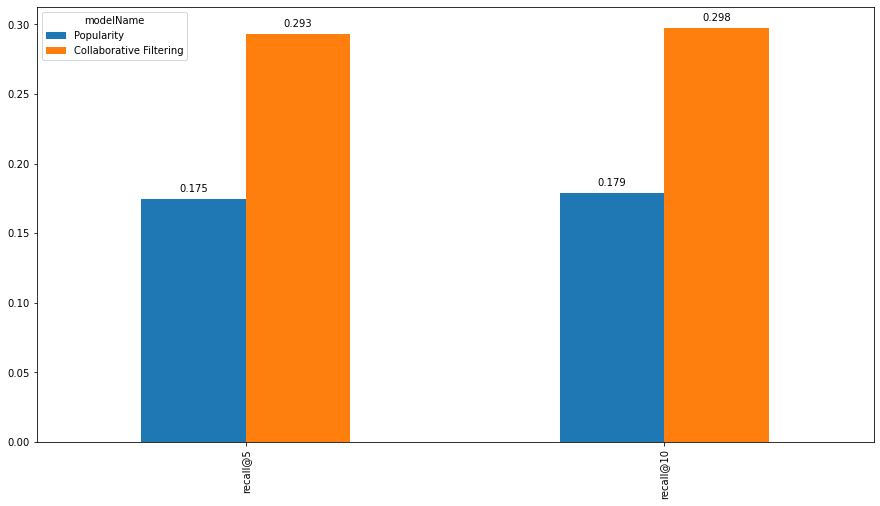

In [192]:
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

## Testing

In [201]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(products_df, how = 'left', 
                                                      left_on = 'productid', 
                                                      right_on = 'productid') \
                          .sort_values('quantity', ascending = False)[['quantity', 'productid']]

In [202]:
test_customers = list(interactions_test_df['customerid'].unique())

In [205]:
person_id=random.choices(test_customers, k=1)[0]

In [206]:
inspect_interactions(person_id, test_set=False).head(20)

,quantity,productid
21,6.599913,3565
34,4.643856,10
29,4.643856,1453
24,4.643856,1454
11,4.643856,2519
8,4.392317,971
1,4.247928,1087
20,4.087463,235
0,3.700440,2330
15,3.700440,2872


In [208]:
cf_recommender_model.recommend_items(person_id, topn=20, verbose=True)

,productid,description
0,3565,WORLD WAR 2 GLIDERS ASSTD DESIGNS
1,3401,VINTAGE SNAP CARDS
2,1914,MINI PAINT SET VINTAGE
3,2519,RED HARMONICA IN BOX
4,3536,WOODEN BOX OF DOMINOES
5,3369,VINTAGE HEADS AND TAILS CARD GAME
6,3256,TRADITIONAL MODELLING CLAY
7,2102,PACK OF 12 TRADITIONAL CRAYONS
8,2167,PAPER CHAIN KIT 50'S CHRISTMAS
9,2287,PINK CREAM FELT CRAFT TRINKET BOX
